<a href="https://colab.research.google.com/github/yastiaisyah/DataSynthesis/blob/main/12_10_23_adversarial_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


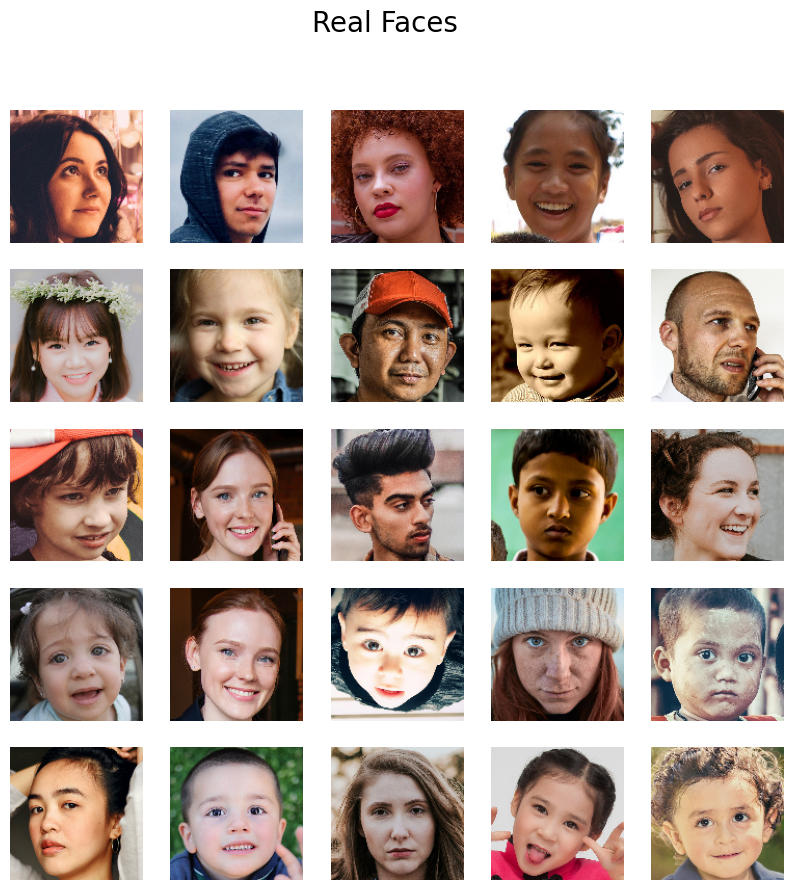

In [3]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import models
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from torch.autograd import Variable
from torchvision import transforms

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from google.colab import drive
drive.mount('/content/drive')

# Load dataset gambar wajah nyata dan palsu
real_dir = r'/content/drive/MyDrive/dataset/real_and_fake_face/training_real/'
real_path = os.listdir(real_dir)

fake_dir = r'/content/drive/MyDrive/dataset/real_and_fake_face/training_fake/'
fake_path = os.listdir(fake_dir)

# Define the target size for resizing
target_size = (128, 128)  # Adjust to the desired size

# Create a list to store resized images
resized_images = []

# Loop through the image files and resize them
for image_file in real_path:
    # Construct the full path to the image
    image_path = os.path.join(real_dir, image_file)

    # Open the image using OpenCV
    image = cv2.imread(image_path)

    # Resize the image using OpenCV
    image = cv2.resize(image, target_size)

    # Convert the OpenCV image to a Pillow (PIL) image
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Append the resized image to the list
    resized_images.append(pil_image)

# Now, the resized images are stored in the `resized_images` list, and you can use them in your code.

# Buat subplot dengan ukuran 5x5
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Atur judul subplot
fig.suptitle("Real Faces", fontsize=20)

# Loop untuk menampilkan gambar
for i in range(25):
    row = i // 5
    col = i % 5

    # Ubah gambar PIL menjadi numpy array
    img_array = np.array(resized_images[i])

    # Tampilkan gambar di subplot
    axes[row, col].imshow(img_array, cmap='gray')
    axes[row, col].axis('off')

plt.show()

In [4]:
# Parameters
batch_size = 64
image_size = 64
z_dim = 100  # Dimensi vektor noise

from torchvision.transforms import ToTensor

transform = ToTensor()

def collate_fn(batch):
    return [ToTensor()(item) for item in batch]

real_data_loader = torch.utils.data.DataLoader(resized_images, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Definisi Generator
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Unflatten(1, (256, 1, 1)),  # Reshape menjadi citra 1x1
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, noise):
        img = self.model(noise)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# Dimensi input untuk generator (z_dim) dan gambar (img_dim)
z_dim = 100
img_dim = 49152  # 128x128x3

# Inisialisasi generator dan discriminator
G = Generator(z_dim, img_dim)
D = Discriminator(img_dim)
